In [1]:
pip install open3d

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show open3d

Name: open3d
Version: 0.16.0
Summary: UNKNOWN
Home-page: http://www.open3d.org
Author: Open3D Team
Author-email: info@open3d.org
License: MIT
Location: c:\users\admin\anaconda3\lib\site-packages
Requires: configargparse, dash, ipywidgets, nbformat, numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import imageio as iio
# monkey patches visualization and provides helpers to load geometries
#sys.path.append('Open3D-master/examples/python/')
#import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
#o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# Load in color and depth image to create the point cloud
print("Read Redwood dataset")
color_raw = o3d.io.read_image("C:/Users/Admin/Desktop/rgb_img_01.jpg")
depth_raw = o3d.io.read_image("C:/Users/Admin/Desktop/depth_img_01.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)

Read Redwood dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


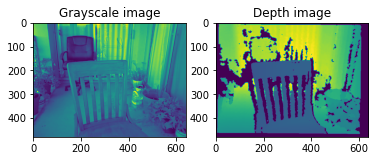

In [5]:
# Plot the images
plt.subplot(1, 2, 1)
plt.title('Grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Depth image')
plt.imshow(rgbd_image.depth)
plt.show()

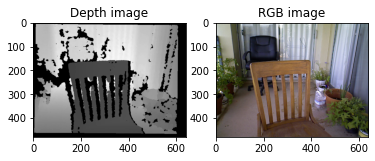

In [6]:
# Read the rgb image:
rgb_image = iio.imread("C:/Users/Admin/Desktop/rgb_img_01.jpg")
depth_image = iio.imread("C:/Users/Admin/Desktop/depth_img_01.png")

# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
plt.show()

In [7]:
# Depth camera parameters:
FX_DEPTH = 5.8262448167737955e+02
FY_DEPTH = 5.8269103270988637e+02
CX_DEPTH = 3.1304475870804731e+02
CY_DEPTH = 2.3844389626620386e+02

In [8]:
pcd = []
height, width = depth_image.shape
for i in range(height):
   for j in range(width):
       z = depth_image[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])
print(pcd[10])

[-0.0, -0.0, 0]


In [9]:
# Rotation matrix:
R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
# Translation vector:
T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

In [10]:
[x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

In [11]:
# RGB camera intrinsic Parameters:
FX_RGB = 5.1885790117450188e+02
FY_RGB = 5.1946961112127485e+02
CX_RGB = 3.2558244941119034e+0
CY_RGB = 2.5373616633400465e+02

In [12]:
j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

In [13]:
colors = []
pcd = []
for i in range(height):
    for j in range(width):
        """
            Convert the pixel from depth coordinate system
            to depth sensor 3D coordinate system
        """
        z = depth_image[i][j]
        x = (j - CX_DEPTH) * z / FX_DEPTH
        y = (i - CY_DEPTH) * z / FY_DEPTH

        """
            Convert the point from depth sensor 3D coordinate system
            to rgb camera coordinate system:
        """
        [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

        """
            Convert from rgb camera coordinates system
            to rgb image coordinates system:
        """
        j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
        i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

        # Add point to point cloud:
        pcd.append([x, y, z])

        # Add the color of the pixel if it exists:
        if 0 <= j_rgb < width and 0 <= i_rgb < height:
            colors.append(rgb_image[i_rgb][j_rgb] / 255)
        else:
            colors.append([0., 0., 0.])
            
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

In [14]:
''''with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(intrinsic, depth=9)
o3d.visualization.draw_geometries([mesh], zoom=0.664, front=[-0.4761, -0.469, -0.7434], 
                                  lookat = [1.8900, 3.2596, 0.09284], up = [0.2304, -0.8825, 0.4101])''''''

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_996/3988482625.py, line 4)

In [ ]:
o3d.io.write_point_cloud("copy.ply", pcd_o3d)

In [ ]:
print("Downsample the point cloud with a voxel of 0.05")
import open3d as o3d
input_file='copy.ply'
pcd = o3d.io.read_point_cloud(input_file)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=1.5)
pcd_o3d.estimate_normals(
search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
print("last one")
o3d.visualization.draw_geometries([pcd_o3d],
                                  point_show_normal=True)

In [ ]:
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height,  FX_DEPTH,  FY_DEPTH,  CX_DEPTH,  CX_DEPTH)
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_o3d, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh]
                                  )